In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax.numpy as jnp

from fiesta.inference.lightcurve_model import AfterglowFlux
from fiesta.utils import load_event_data
from fiesta.inference.likelihood import EMLikelihood
from fiesta.plot import corner_plot, LightcurvePlotter
from fiesta.train.AfterglowData import RunAfterglowpy
from fiesta.filters import Filter


In [39]:
posterior = pd.DataFrame(dict(np.load("./afgpy/posterior.npz")))

posterior_first_mode = posterior[posterior["inclination_EM"]<=1.2].reset_index(drop=True)
posterior_second_mode = posterior[posterior["inclination_EM"]>1.2].reset_index(drop=True)

########
# DATA #
########

data = load_event_data("../../data/GRB170817A.dat")
trigger_time = 57982.52851852
FILTERS = data.keys()

#########
# MODEL #
#########

model = AfterglowFlux(name="afgpy_gaussian_CVAE",
                      filters = FILTERS)

detection_limit = None
likelihood = EMLikelihood(model,
                          data,
                          tmin=1.,
                          tmax=2000.0,
                          trigger_time=trigger_time,
                          detection_limit = detection_limit,
                          fixed_params={"luminosity_distance": 43.58, "redshift": 0.009727}
                          )

15:01 fiesta INFO    : Loading surrogate afgpy_gaussian_CVAE. This surrogate should only be used in the following parameter ranges:
15:01 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
15:01 fiesta INFO    : 	 log10_E0: (47, 57)
15:01 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
15:01 fiesta INFO    : 	 alphaWing: (0.2, 3.5)
15:01 fiesta INFO    : 	 log10_n0: (-6, 2)
15:01 fiesta INFO    : 	 p: (2.01, 3)
15:01 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
15:01 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)
15:01 fiesta INFO    : Surrogate afgpy_gaussian_CVAE is loading with source-frame time range [1.e-04 2.e+03] days.
15:01 fiesta INFO    : Surrogate afgpy_gaussian_CVAE is loading with the following filters: ['X-ray-1keV', 'bessellv', 'radio-3GHz', 'radio-6GHz'].
15:01 fiesta INFO    : Loaded for surrogate afgpy_gaussian_CVAE from /nfs/aya/work/hkoehn/fiesta/fiesta/src/fiesta/surrogates/GRB/afgpy_gaussian_CVAE/model.
15:01 fiesta INFO    : Loading and preprocessing

In [40]:
lc_plotter_first_mode = LightcurvePlotter(posterior_first_mode,
                               likelihood,
                               systematics_file = "./systematics_file.yaml")

lc_plotter_second_mode = LightcurvePlotter(posterior_second_mode,
                               likelihood,
                               systematics_file = "./systematics_file.yaml")

In [66]:
def run_afgpy(best_fit_params):

    X = np.array([[best_fit_params[key] for key in model.parameter_names]])

    afgpy = RunAfterglowpy(0, model.times, model.nus, X, parameter_names=model.parameter_names)
    _, mJys = afgpy(0)
    mJys= np.exp(mJys).reshape(len(model.nus), len(model.times))
    return mJys

mJys_first_mode = run_afgpy(lc_plotter_first_mode.best_fit_params)
mJys_second_mode = run_afgpy(lc_plotter_second_mode.best_fit_params)

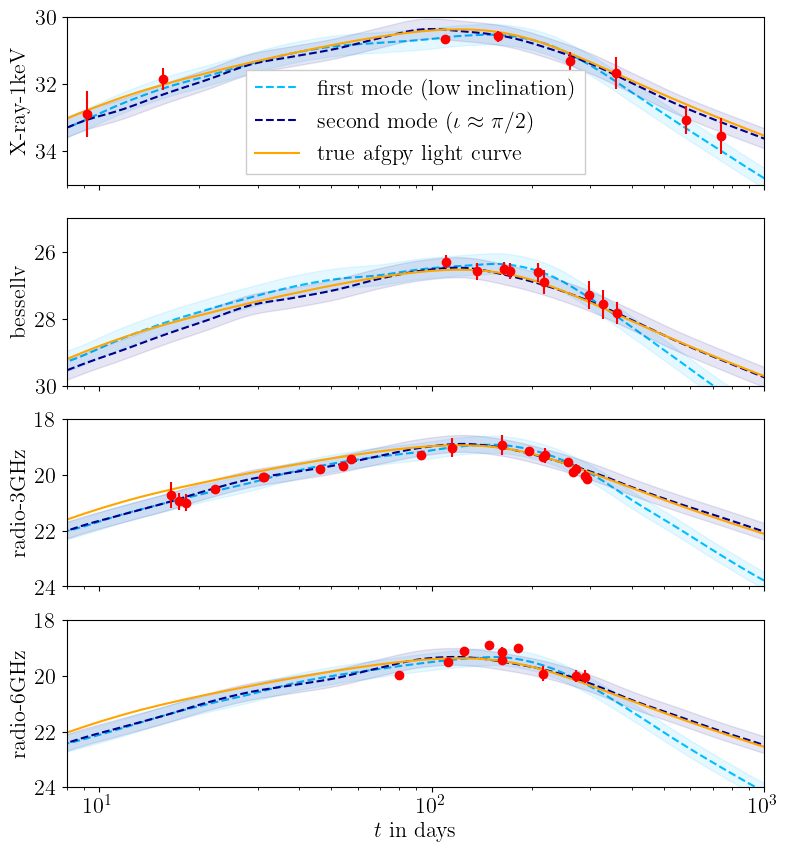

In [88]:
fig, ax = plt.subplots(4, figsize= (9, 10), sharex=True)


for cax, filt in zip(ax, likelihood.filters):

    lc_plotter_first_mode.plot_best_fit_lc(cax, filt, color="deepskyblue", label="first mode (low inclination)", linestyle="dashed")
    lc_plotter_first_mode.plot_sys_uncertainty_band(cax, filt, color="deepskyblue")
    lc_plotter_second_mode.plot_best_fit_lc(cax, filt, color="darkblue", label="second mode ($\\iota \\approx \\pi/2$)", linestyle="dashed")
    lc_plotter_second_mode.plot_sys_uncertainty_band(cax, filt, color="darkblue")

    #cax.plot(model.times, Filter(filt).get_mag(mJys_first_mode, model.nus) + 5*np.log10(43.58*1e6) -5, color="red")
    cax.plot(model.times, Filter(filt).get_mag(mJys_second_mode, model.nus) + 5*np.log10(43.58*1e6) -5, color="orange", label="true afgpy light curve")

    lc_plotter_first_mode.plot_data(cax, filt, color="red")

    cax.set_xscale("log")
    cax.set_xlim(8, 1000)
    cax.invert_yaxis()
    cax.set_ylabel(filt)

ax[0].set_ylim((35, 30))
ax[1].set_ylim((30, 25))
ax[2].set_ylim((24, 18))
ax[3].set_ylim((24, 18))

ax[0].legend(fancybox=False, framealpha=1)


ax[-1].set_xlabel("$t$ in days")

fig.savefig("lc_plots_with_real_afgpy_lc.pdf", dpi=250)

In [70]:
Filter(filt).get_mag(mJys_second_mode, model.nus) + 5*np.log10(43.58*1e6) -5

Array([93.668755, 93.25337 , 92.83798 , 92.42259 , 92.00721 , 91.59183 ,
       91.17644 , 90.76105 , 90.345665, 89.930275, 89.51489 , 89.0995  ,
       88.68411 , 88.26874 , 87.85335 , 87.43796 , 87.022575, 86.607185,
       86.1918  , 85.77641 , 85.36102 , 84.94564 , 84.53025 , 84.11487 ,
       83.69948 , 83.28409 , 82.868706, 82.45332 , 82.03793 , 81.62254 ,
       81.20716 , 80.79178 , 80.37639 , 79.961   , 79.545616, 79.130226,
       78.71484 , 78.29945 , 77.88406 , 77.46868 , 77.0533  , 76.63791 ,
       76.22252 , 75.80714 , 75.391754, 74.976364, 74.55654 , 74.11713 ,
       73.65231 , 73.169846, 72.678925, 72.184235, 71.68649 , 71.18579 ,
       70.6816  , 70.174095, 69.66449 , 69.15405 , 68.643074, 68.13173 ,
       67.61992 , 67.107635, 66.59505 , 66.08232 , 65.56949 , 65.05661 ,
       64.5437  , 64.03069 , 63.51764 , 63.004578, 62.4915  , 61.97841 ,
       61.46531 , 60.952194, 60.439087, 59.925964, 59.41284 , 58.899727,
       58.3866  , 57.873474, 57.360348, 56.84722 , 

In [45]:
lc_plotter_first_mode.best_fit_params

{'inclination_EM': 0.3766808,
 'log10_E0': 53.675903,
 'thetaCore': 0.05855501,
 'alphaWing': 3.4861233,
 'log10_n0': -2.2398167,
 'p': 2.1140213,
 'log10_epsilon_e': -2.8131332,
 'log10_epsilon_B': -2.9403074,
 'syserr_collective_1': 0.30546242,
 'log_prob': -13.573902,
 'luminosity_distance': 43.58,
 'redshift': 0.009727}

In [46]:
lc_plotter_second_mode.best_fit_params

{'inclination_EM': 1.5596989,
 'log10_E0': 52.84185,
 'thetaCore': 0.29339746,
 'alphaWing': 3.0875154,
 'log10_n0': 1.8548826,
 'p': 2.1556242,
 'log10_epsilon_e': -1.425154,
 'log10_epsilon_B': -6.9215317,
 'syserr_collective_1': 0.3002028,
 'log_prob': -15.740302,
 'luminosity_distance': 43.58,
 'redshift': 0.009727}